# Trading Strategy using stock clustering

* Load S&P 500 price data.
* Compute features and technical indicators for each stock.
* Aggregate monthly and keep the most liquid stocks.
* Compute monthly returns over various horizons.
* Add Fama-French factors and estimate rolling betas.
* Each month, cluster stocks with K-Means by feature similarity.
* Build a portfolio from selected clusters using Efficient Frontier (max Sharpe).
* Compare portfolio performance to the S&P 500.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import time
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
import requests
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
warnings.filterwarnings('ignore')

## 1. Download/Load SP500 stocks prices data.

In [2]:
def download_data(end_date='2023-09-27', nb_years=8):
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

    # Simuler un navigateur
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)

    # Lire le HTML avec pandas
    sp500 = pd.read_html(response.text)[0]

    # Nettoyage
    sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
    symbols_list = sp500['Symbol'].unique().tolist()

    start_date = pd.to_datetime(end_date)-pd.DateOffset(365*int(nb_years))
    df = yf.download(tickers=symbols_list, start=start_date, end=end_date, auto_adjust=True).stack()

    df.index.names = ['date', 'ticker']
    df = df.reset_index(level='ticker')  
    df.index = df.index.tz_localize(None)  
    df = df.set_index('ticker', append=True)  
    df.columns = df.columns.str.lower()
    return df

#df = download_data(end_date='2023-09-27', nb_years=8)
df = pd.read_parquet('sp500_data.parquet')

In [3]:
df.head()

Price              adj close      close       high        low       open  \
date       ticker                                                          
2015-09-29 A             NaN  31.122833  31.418011  30.661618  30.772308   
           AAPL          NaN  24.508568  25.508598  24.238898  25.355784   
           ABBV          NaN  34.512173  35.427440  33.917248  34.714838   
           ABT           NaN  32.529430  33.064726  32.142370  32.331782   
           ACGL          NaN  23.217773  23.255808  22.916655  22.983217   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
           ACGL      1888800.0

## 2. Calculate features and technical indicators for each stock.

* RSI
* Garman-Klass Volatility
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [4]:
def compute_rsi(stock_data):
    return pandas_ta.rsi(close=stock_data['close'], length=14)

def compute_atr(stock_data):
    return pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], close=stock_data['close'], length=20)

def compute_macd(stock_data):
    return pandas_ta.macd(close=stock_data['close'], length=20).iloc[:,0]


df['rsi'] = df.groupby(level='ticker', group_keys=False).apply(compute_rsi)
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['close'])-np.log(df['open']))**2)
df['atr'] = df.groupby(level='ticker', group_keys=False).apply(compute_atr)
df['macd'] = df.groupby(level='ticker', group_keys=False).apply(compute_macd)
df['dollar_volume'] = (df['close']*df['volume'])/1e6

## 3. Aggregate to monthly level and filter top most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.
* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [5]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open','high', 'low', 'adj close']]
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack('ticker')[last_cols].resample('M').last().stack('ticker')], axis=1)).dropna()
data['dollar_volume'] = data['dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack()
data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)
data

close        rsi  garman_klass_vol       atr      macd
date       ticker                                                             
2016-10-31 AAPL     26.060886  44.293378          0.000041  0.408635  0.161474
           ABBV     38.226246  23.549741          0.000192  0.880602 -0.772621
           ABT      33.321087  35.221910          0.000024  0.634955 -0.497356
           ACN     101.253754  54.032135          0.000033  1.436103  0.300039
           ADBE    107.510002  50.680311          0.000059  1.520766  0.680536
...                       ...        ...               ...       ...       ...
2023-09-30 WDAY    229.240005  38.599005          0.000141  5.191926 -0.674199
           WFC      38.418465  38.130794          0.000234  0.867204 -0.227649
           WMT      52.929115  52.758244          0.000024  0.587166  0.306425
           XOM     108.542068  59.377715          0.000045  1.987650  1.763678
           XYZ      44.810001  21.425932          0.000338  2.037784 -4.117488

[12516 rows x 5 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [6]:
def calculate_returns(stock_data):
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]
    for lag in lags:
        stock_data[f'return_{lag}m'] = (stock_data['close']
                                        .pct_change(lag)
                                        .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff), upper=x.quantile(1-outlier_cutoff)))
                                        .add(1).pow(1/lag).sub(1))
    return stock_data
    
data = data.groupby(level='ticker', group_keys=False).apply(calculate_returns).dropna()
data

close        rsi  garman_klass_vol       atr  \
date       ticker                                                      
2017-10-31 AAPL     39.484219  74.606790          0.000112  0.591711   
           ABBV     64.105515  50.876438          0.000173  1.638628   
           ABT      47.118382  49.081237          0.000036  0.635077   
           ACN     126.506302  71.187983          0.000019  1.421585   
           ADBE    175.160004  72.005982          0.000067  3.261455   
...                       ...        ...               ...       ...   
2023-09-30 WDAY    229.240005  38.599005          0.000141  5.191926   
           WFC      38.418465  38.130794          0.000234  0.867204   
           WMT      52.929115  52.758244          0.000024  0.587166   
           XOM     108.542068  59.377715          0.000045  1.987650   
           XYZ      44.810001  21.425932          0.000338  2.037784   

                       macd  return_1m  return_2m  return_3m  return_6m  \
date       ticker                                                         
2017-10-31 AAPL    0.465228   0.096807   0.015250   0.044955   0.028875   
           ABBV    1.068059   0.022728   0.098590   0.091379   0.056495   
           ABT     0.537070   0.021276   0.034308   0.034801   0.038672   
           ACN     2.015521   0.064180   0.048455   0.037203   0.028692   
           ADBE    6.690559   0.174152   0.062497   0.061392   0.045993   
...                     ...        ...        ...        ...        ...   
2023-09-30 WDAY   -0.674199  -0.062413  -0.016777   0.004919   0.017531   
           WFC    -0.227649  -0.015500  -0.057917  -0.013554   0.016712   
           WMT     0.306425  -0.000676   0.010014   0.012354   0.017574   
           XOM     1.763678   0.046947   0.046139   0.030496   0.012838   
           XYZ    -4.117488  -0.222723  -0.247423  -0.123607  -0.068630   

                   return_9m  return_12m  
date       ticker                         
2017-10-31 AAPL     0.038941    0.035228  
           ABBV     0.047273    0.044026  
           ABT      0.031320    0.029294  
           ACN      0.027398    0.018728  
           ADBE     0.049515    0.041515  
...                      ...         ...  
2023-09-30 WDAY     0.035597    0.034709  
           WFC      0.000702    0.003255  
           WMT      0.016553    0.020256  
           XOM      0.008747    0.027037  
           XYZ     -0.036876   -0.016915  

[10335 rows x 11 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [7]:
#factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0].drop('RF', axis=1)
factor_data = pd.read_parquet('famafrench_data.parquet')
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAPL    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.096807
           ABBV    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.022728
           ABT     0.0225 -0.0191  0.0013  0.0092 -0.0314   0.021276
           ACN     0.0225 -0.0191  0.0013  0.0092 -0.0314   0.064180
           ADBE    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.174152
...                   ...     ...     ...     ...     ...        ...
2023-09-30 WDAY   -0.0523 -0.0178  0.0149  0.0188 -0.0077  -0.062413
           WFC    -0.0523 -0.0178  0.0149  0.0188 -0.0077  -0.015500
           WMT    -0.0523 -0.0178  0.0149  0.0188 -0.0077  -0.000676
           XOM    -0.0523 -0.0178  0.0149  0.0188 -0.0077   0.046947
           XYZ    -0.0523 -0.0178  0.0149  0.0188 -0.0077  -0.222723

[10335 rows x 6 columns]

* Filter out stocks with less than 10 months of data.
* Calculate Rolling Factor Betas.
* Join the rolling factors data to the main features dataframe.

In [8]:
observations = factor_data.groupby(level='ticker').size()
valid_stocks = observations[observations >= 10]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

##### On 2 years
betas = (factor_data.groupby(level='ticker', group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]), min_nobs=len(x.columns)+1)
         .fit(params_only=True).params.drop('const', axis=1)))

factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data = data.join(betas)
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.drop('close', axis=1)
data = data.dropna()
data.info() 

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10315 entries, (Timestamp('2017-10-31 00:00:00'), 'AAPL') to (Timestamp('2023-09-30 00:00:00'), 'XYZ')
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rsi               10315 non-null  float64
 1   garman_klass_vol  10315 non-null  float64
 2   atr               10315 non-null  float64
 3   macd              10315 non-null  float64
 4   return_1m         10315 non-null  float64
 5   return_2m         10315 non-null  float64
 6   return_3m         10315 non-null  float64
 7   return_6m         10315 non-null  float64
 8   return_9m         10315 non-null  float64
 9   return_12m        10315 non-null  float64
 10  Mkt-RF            10315 non-null  float64
 11  SMB               10315 non-null  float64
 12  HML               10315 non-null  float64
 13  RMW               10315 non-null  float64
 14  CMA               10315 non-null  float64
dtypes: float64

In [9]:
data

rsi  garman_klass_vol       atr      macd  return_1m  \
date       ticker                                                               
2017-10-31 AAPL    74.606790          0.000112  0.591711  0.465228   0.096807   
           ABBV    50.876438          0.000173  1.638628  1.068059   0.022728   
           ABT     49.081237          0.000036  0.635077  0.537070   0.021276   
           ACN     71.187983          0.000019  1.421585  2.015521   0.064180   
           ADBE    72.005982          0.000067  3.261455  6.690559   0.174152   
...                      ...               ...       ...       ...        ...   
2023-09-30 WDAY    38.599005          0.000141  5.191926 -0.674199  -0.062413   
           WFC     38.130794          0.000234  0.867204 -0.227649  -0.015500   
           WMT     52.758244          0.000024  0.587166  0.306425  -0.000676   
           XOM     59.377715          0.000045  1.987650  1.763678   0.046947   
           XYZ     21.425932          0.000338  2.037784 -4.117488  -0.222723   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2017-10-31 AAPL     0.015250   0.044955   0.028875   0.038941    0.035228   
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026   
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294   
           ACN      0.048455   0.037203   0.028692   0.027398    0.018728   
           ADBE     0.062497   0.061392   0.045993   0.049515    0.041515   
...                      ...        ...        ...        ...         ...   
2023-09-30 WDAY    -0.016777   0.004919   0.017531   0.035597    0.034709   
           WFC     -0.057917  -0.013554   0.016712   0.000702    0.003255   
           WMT      0.010014   0.012354   0.017574   0.016553    0.020256   
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037   
           XYZ     -0.247423  -0.123607  -0.068630  -0.036876   -0.016915   

                     Mkt-RF       SMB       HML       RMW       CMA  
date       ticker                                                    
2017-10-31 AAPL    1.275340 -0.248551 -0.603890  0.670964  0.478249  
           ABBV    0.502641  0.353441 -0.033197  0.183414  0.202035  
           ABT     0.831665 -0.185107 -0.525634  0.262914  0.983600  
           ACN     1.204271 -0.159713 -0.338906  0.273504  0.191039  
           ADBE    1.120338 -0.332286 -0.173422 -0.213075 -0.689530  
...                     ...       ...       ...       ...       ...  
2023-09-30 WDAY    1.080997 -0.944552 -0.562809 -0.905698 -0.246555  
           WFC     1.121960  0.241156  2.053292 -0.498172 -1.545368  
           WMT     0.703760 -0.314501 -0.404439 -0.144511  0.500038  
           XOM     0.983111 -1.132612  1.727677 -0.686521 -0.356411  
           XYZ     2.417982  1.928899 -0.345458 -1.677475  0.481122  

[10315 rows x 15 columns]

## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

* Data preprocessing and finding the optimal number of clusters using the Elbow method.

In [10]:
def normalize_features(df, cols):
    ### cross sectional Z-scoring of features
    df_copy = df.copy()
    for c in cols:
        df_copy[c] = df_copy.groupby(level='date', group_keys=False)[c].apply(lambda x: (x - x.mean()) / x.std())
    return df_copy

def find_nb_clust(df, K_values):
    inertias = []
    for k in K_values:
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
        kmeans.fit(df)
        inertias.append(kmeans.inertia_)
    return inertias

In [11]:
cols = [c for c in data.columns if c!='rsi']
data1 = normalize_features(data, cols)

In [12]:
data1

rsi  garman_klass_vol       atr      macd  return_1m  \
date       ticker                                                               
2017-10-31 AAPL    74.606790         -0.133323 -0.424405 -0.041665   1.146619   
           ABBV    50.876438          0.052376 -0.055370  0.221821   0.031014   
           ABT     49.081237         -0.364871 -0.409118 -0.010264   0.009140   
           ACN     71.187983         -0.417764 -0.131876  0.635937   0.655269   
           ADBE    72.005982         -0.271356  0.516672  2.679300   2.311403   
...                      ...               ...       ...       ...        ...   
2023-09-30 WDAY    38.599005         -0.080087  0.133159  0.099655  -0.240089   
           WFC     38.130794          0.787653 -0.485651  0.244832   0.599391   
           WMT     52.758244         -1.178247 -0.525721  0.418465   0.864655   
           XOM     59.377715         -0.981100 -0.325330  0.892230   1.716843   
           XYZ     21.425932          1.769092 -0.318157 -1.019790  -3.108755   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2017-10-31 AAPL    -0.217642   0.758303   0.502998   1.046739    0.818519   
           ABBV     1.583928   2.004766   1.526028   1.414424    1.265672   
           ABT      0.194347   0.485665   0.865892   0.710389    0.516854   
           ACN      0.500148   0.550152   0.496251   0.537312   -0.020167   
           ADBE     0.803693   1.199612   1.137066   1.513363    1.138058   
...                      ...        ...        ...        ...         ...   
2023-09-30 WDAY     0.482250   0.492938   0.479379   0.766442    0.812920   
           WFC     -0.352333  -0.001277   0.451876  -0.309895   -0.530956   
           WMT      1.025747   0.691841   0.480823   0.179037    0.195430   
           XOM      1.758602   1.177180   0.321719  -0.061747    0.485153   
           XYZ     -4.196743  -2.945491  -2.415066  -1.469032   -1.392730   

                     Mkt-RF       SMB       HML       RMW       CMA  
date       ticker                                                    
2017-10-31 AAPL    0.641068 -0.571859 -1.188431  0.747234  0.518993  
           ABBV   -1.376841  0.546864 -0.291284  0.166837  0.178921  
           ABT    -0.517593 -0.453957 -1.065410  0.261478  1.141177  
           ACN     0.455470 -0.406765 -0.771869  0.274084  0.165382  
           ADBE    0.236280 -0.727469 -0.511723 -0.305156 -0.918767  
...                     ...       ...       ...       ...       ...  
2023-09-30 WDAY   -0.025252 -0.770571 -0.824020 -0.633286 -0.369969  
           WFC     0.043781  0.208535  2.574209 -0.326835 -1.790969  
           WMT    -0.660979 -0.250302 -0.618302 -0.060889  0.446861  
           XOM    -0.190211 -0.925864  2.151246 -0.468469 -0.490160  
           XYZ     2.227864  1.602202 -0.541687 -1.213647  0.426166  

[10315 rows x 15 columns]

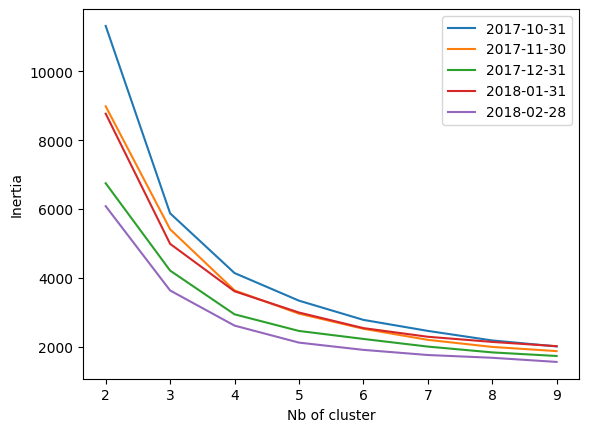

In [13]:
dates = data1.index.get_level_values(0).unique()
for d in dates[:5]:
    K_values = np.arange(2, 10)
    inertias = find_nb_clust(data1.loc[d], K_values)
    plt.plot(K_values, inertias, label=d.date())
    plt.xlabel('Nb of cluster')
    plt.ylabel('Inertia')
    plt.legend()
plt.show()

#### $Nb_{clusters} = 4$ works well.

In [14]:
def get_clusters(df_or, k):
    df = df_or.copy()
    model = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42).fit(df)
    df['cluster'] = model.labels_
    norms = {}
    for c in range(k):
        center = model.cluster_centers_[c]
        #points = df[df['cluster'] == c].drop(columns=['cluster']).to_numpy()
        #norms[c] = np.mean((points - center) ** 2)  ## Mean inertia
        norms[c] = np.linalg.norm(center, ord=2)  ## L2 norm of centroid
    df['norm'] = df['cluster'].map(norms)
    rank_map = {cluster: rank + 1 for rank, cluster in enumerate(sorted(norms, key=norms.get))}
    df['Id'] = df['cluster'].map(rank_map)
    return df.drop(columns=['cluster'])

data1 = data1.dropna().groupby('date', group_keys=False).apply(lambda df: get_clusters(df, k=4))

In [15]:
data1

rsi  garman_klass_vol       atr      macd  return_1m  \
date       ticker                                                               
2017-10-31 AAPL    74.606790         -0.133323 -0.424405 -0.041665   1.146619   
           ABBV    50.876438          0.052376 -0.055370  0.221821   0.031014   
           ABT     49.081237         -0.364871 -0.409118 -0.010264   0.009140   
           ACN     71.187983         -0.417764 -0.131876  0.635937   0.655269   
           ADBE    72.005982         -0.271356  0.516672  2.679300   2.311403   
...                      ...               ...       ...       ...        ...   
2023-09-30 WDAY    38.599005         -0.080087  0.133159  0.099655  -0.240089   
           WFC     38.130794          0.787653 -0.485651  0.244832   0.599391   
           WMT     52.758244         -1.178247 -0.525721  0.418465   0.864655   
           XOM     59.377715         -0.981100 -0.325330  0.892230   1.716843   
           XYZ     21.425932          1.769092 -0.318157 -1.019790  -3.108755   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2017-10-31 AAPL    -0.217642   0.758303   0.502998   1.046739    0.818519   
           ABBV     1.583928   2.004766   1.526028   1.414424    1.265672   
           ABT      0.194347   0.485665   0.865892   0.710389    0.516854   
           ACN      0.500148   0.550152   0.496251   0.537312   -0.020167   
           ADBE     0.803693   1.199612   1.137066   1.513363    1.138058   
...                      ...        ...        ...        ...         ...   
2023-09-30 WDAY     0.482250   0.492938   0.479379   0.766442    0.812920   
           WFC     -0.352333  -0.001277   0.451876  -0.309895   -0.530956   
           WMT      1.025747   0.691841   0.480823   0.179037    0.195430   
           XOM      1.758602   1.177180   0.321719  -0.061747    0.485153   
           XYZ     -4.196743  -2.945491  -2.415066  -1.469032   -1.392730   

                     Mkt-RF       SMB       HML       RMW       CMA  \
date       ticker                                                     
2017-10-31 AAPL    0.641068 -0.571859 -1.188431  0.747234  0.518993   
           ABBV   -1.376841  0.546864 -0.291284  0.166837  0.178921   
           ABT    -0.517593 -0.453957 -1.065410  0.261478  1.141177   
           ACN     0.455470 -0.406765 -0.771869  0.274084  0.165382   
           ADBE    0.236280 -0.727469 -0.511723 -0.305156 -0.918767   
...                     ...       ...       ...       ...       ...   
2023-09-30 WDAY   -0.025252 -0.770571 -0.824020 -0.633286 -0.369969   
           WFC     0.043781  0.208535  2.574209 -0.326835 -1.790969   
           WMT    -0.660979 -0.250302 -0.618302 -0.060889  0.446861   
           XOM    -0.190211 -0.925864  2.151246 -0.468469 -0.490160   
           XYZ     2.227864  1.602202 -0.541687 -1.213647  0.426166   

                        norm  Id  
date       ticker                 
2017-10-31 AAPL    71.821243   4  
           ABBV    55.876514   3  
           ABT     55.876514   3  
           ACN     71.821243   4  
           ADBE    71.821243   4  
...                      ...  ..  
2023-09-30 WDAY    35.331150   2  
           WFC     35.331150   2  
           WMT     57.072228   4  
           XOM     57.072228   4  
           XYZ     25.656194   1  

[10315 rows x 17 columns]

In [16]:
def plot_clusters(data, x, y):
    cluster_1 = data[data['Id']==1]
    cluster_2 = data[data['Id']==2]
    cluster_3 = data[data['Id']==3]
    cluster_4 = data[data['Id']==4]

    plt.scatter(cluster_1[x], cluster_1[y], color='green', label='cluster 1')
    plt.scatter(cluster_2[x], cluster_2[y], color='blue', label='cluster 2')
    plt.scatter(cluster_3[x], cluster_3[y], color='black', label='cluster 3')
    plt.scatter(cluster_4[x], cluster_4[y], color='red', label='cluster 4')
    
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.show()
    return


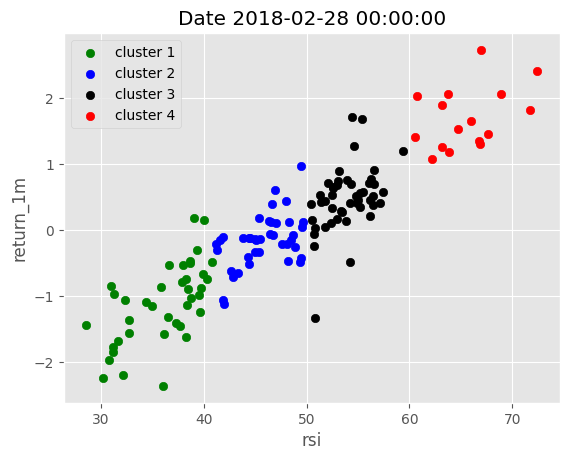

In [17]:
plt.style.use('ggplot')
for i in dates[4:5]:
    g = data1.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g, x='rsi', y='return_1m')

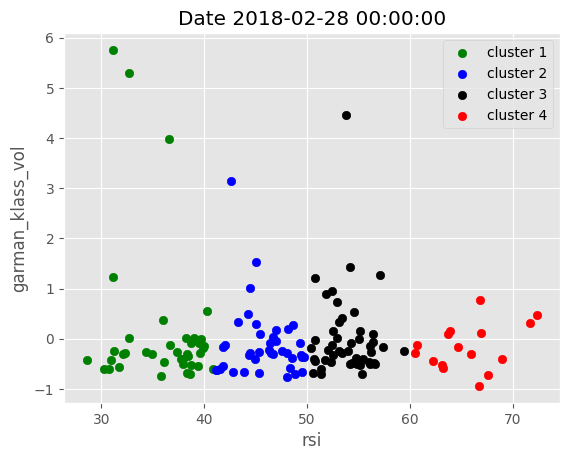

In [18]:
plt.style.use('ggplot')
for i in dates[4:5]:
    g = data1.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g, x='rsi', y='garman_klass_vol')

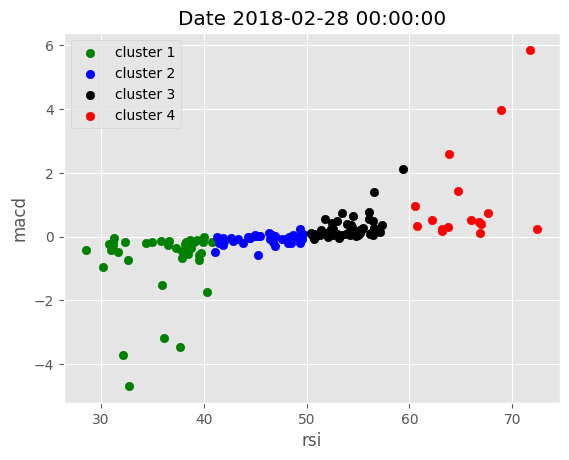

In [22]:
plt.style.use('ggplot')
for i in dates[4:5]:
    g = data1.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g, x='rsi', y='macd')

For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I will bet on clusters 4

* This strategy will be compare to some one else consisting of taking 25% of stocks having the highest RSI.


In [24]:
def compute_df_dates(df_or):
    df = df_or.copy()
    df = df.reset_index(level=1)
    df.index = df.index+pd.DateOffset(1)
    df = df.reset_index().set_index(['date', 'ticker'])
    dates = df.index.get_level_values('date').unique().tolist()
    fixed_dates = {}
    for d in dates:
        fixed_dates[d.strftime('%Y-%m-%d')] = df.xs(d, level=0).index.tolist()
    return fixed_dates

In [28]:
filtered_df1 = data1[data1['Id']==4].copy()
fixed_dates1 = compute_df_dates(filtered_df1)
filtered_df1

rsi  garman_klass_vol       atr      macd  return_1m  \
date       ticker                                                               
2017-10-31 AAPL    74.606790         -0.133323 -0.424405 -0.041665   1.146619   
           ACN     71.187983         -0.417764 -0.131876  0.635937   0.655269   
           ADBE    72.005982         -0.271356  0.516672  2.679300   2.311403   
           AMAT    70.036366         -0.055190 -0.258199  0.519654   0.943463   
           AMZN    76.696841         -0.377176 -0.267654  0.287862   1.943412   
...                      ...               ...       ...       ...        ...   
2023-09-30 UNH     62.492599         -1.109855  0.530357  1.436130   2.034641   
           VLO     54.542440          0.949640 -0.061539  1.458209   2.485746   
           VRTX    52.785949         -1.053376  0.194835  0.628460   1.048851   
           WMT     52.758244         -1.178247 -0.525721  0.418465   0.864655   
           XOM     59.377715         -0.981100 -0.325330  0.892230   1.716843   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2017-10-31 AAPL    -0.217642   0.758303   0.502998   1.046739    0.818519   
           ACN      0.500148   0.550152   0.496251   0.537312   -0.020167   
           ADBE     0.803693   1.199612   1.137066   1.513363    1.138058   
           AMAT     2.010662   1.827289   1.550798   1.884106    1.962440   
           AMZN     0.785859   0.576268   0.549250   0.795232    0.471427   
...                      ...        ...        ...        ...         ...   
2023-09-30 UNH      0.843574   0.849205   0.314151  -0.455484   -0.615062   
           VLO      1.880876   2.168328   0.065843   3.724913    2.670507   
           VRTX     0.803878   0.355760   0.511752   0.351353    0.027964   
           WMT      1.025747   0.691841   0.480823   0.179037    0.195430   
           XOM      1.758602   1.177180   0.321719  -0.061747    0.485153   

                     Mkt-RF       SMB       HML       RMW       CMA  \
date       ticker                                                     
2017-10-31 AAPL    0.641068 -0.571859 -1.188431  0.747234  0.518993   
           ACN     0.455470 -0.406765 -0.771869  0.274084  0.165382   
           ADBE    0.236280 -0.727469 -0.511723 -0.305156 -0.918767   
           AMAT    0.605325  0.959247  0.896920 -0.496763 -0.969142   
           AMZN    0.728689 -1.195608 -0.963090 -0.735185 -0.284177   
...                     ...       ...       ...       ...       ...   
2023-09-30 UNH    -1.007061  0.000945 -0.229096  0.194889  0.227459   
           VLO     4.388973 -7.065874  1.060821  2.821424 -5.187600   
           VRTX   -1.073940 -0.321826 -0.514535  0.001059  0.808105   
           WMT    -0.660979 -0.250302 -0.618302 -0.060889  0.446861   
           XOM    -0.190211 -0.925864  2.151246 -0.468469 -0.490160   

                        norm  Id  
date       ticker                 
2017-10-31 AAPL    71.821243   4  
           ACN     71.821243   4  
           ADBE    71.821243   4  
           AMAT    71.821243   4  
           AMZN    71.821243   4  
...                      ...  ..  
2023-09-30 UNH     57.072228   4  
           VLO     57.072228   4  
           VRTX    57.072228   4  
           WMT     57.072228   4  
           XOM     57.072228   4  

[1833 rows x 17 columns]

In [27]:
def select_top_25_percent_rsi(group):
    sorted_group = group.sort_values(by='rsi', ascending=False)
    return sorted_group.head(int(len(sorted_group)*0.25))

filtered_df2 = data.groupby(level='date').apply(select_top_25_percent_rsi).droplevel(0)
fixed_dates2 = compute_df_dates(filtered_df2)
filtered_df2

rsi  garman_klass_vol        atr      macd  \
date       ticker                                                     
2017-10-31 INTC    90.889211          0.000308   0.631917  1.352889   
           MSFT    81.918627          0.000035   1.058144  1.820810   
           STZ     78.388546          0.000105   2.428766  2.729148   
           CRM     78.375792          0.000071   1.301568  1.634098   
           MAR     78.293450          0.000069   1.508972  2.561810   
...                      ...               ...        ...       ...   
2023-09-30 LLY     46.583471          0.000061  11.149329  6.762490   
           BKNG    46.185148          0.000134  64.031529  1.431892   
           OXY     45.902212          0.000119   1.398575  0.132545   
           BRK-B   45.831769          0.000031   4.102050  1.880397   
           LULU    45.735848          0.000142   8.856073  0.622454   

                   return_1m  return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                          
2017-10-31 INTC     0.194591   0.129766   0.089183   0.041628   0.026279   
           MSFT     0.116660   0.054741   0.047765   0.034893   0.030351   
           STZ      0.098471   0.046376   0.043474   0.041584   0.044138   
           CRM      0.095483   0.035247   0.040686   0.029177   0.029034   
           MAR      0.083620   0.074013   0.047867   0.041142   0.040249   
...                      ...        ...        ...        ...        ...   
2023-09-30 LLY     -0.007561   0.101183   0.055315   0.082515   0.047273   
           BKNG    -0.014315   0.014998   0.042627   0.024143   0.047522   
           OXY      0.008502   0.001534   0.025014   0.002874   0.001244   
           BRK-B   -0.002165   0.010542   0.017691   0.025639   0.016973   
           LULU    -0.001574   0.002810   0.001899   0.007399   0.019340   

                   return_12m    Mkt-RF       SMB       HML       RMW  \
date       ticker                                                       
2017-10-31 INTC      0.024923  0.711721  0.535185 -0.215876  0.187834   
           MSFT      0.029751  0.909092 -0.482892 -0.293718  0.084443   
           STZ       0.023740  1.174457 -0.528765  0.498039  0.395741   
           CRM       0.026057  1.008332 -0.303445 -0.137426  0.103098   
           MAR       0.048404  1.316646  0.385324  0.779682  0.171876   
...                       ...       ...       ...       ...       ...   
2023-09-30 LLY       0.046198  0.430960 -0.993555 -0.515645  0.386941   
           BKNG      0.050983  1.517869 -0.510255  0.527260 -0.500896   
           OXY       0.003170  1.477795 -2.391009  1.727046 -3.066763   
           BRK-B     0.025073  1.008069 -0.749493  0.317466 -0.278247   
           LULU      0.026058  1.282996 -0.829488 -0.818191  0.271171   

                        CMA  
date       ticker            
2017-10-31 INTC    0.680690  
           MSFT   -0.112813  
           STZ    -0.949683  
           CRM    -1.040433  
           MAR    -0.815942  
...                     ...  
2023-09-30 LLY     0.346312  
           BKNG    0.109521  
           OXY     0.151429  
           BRK-B   0.209758  
           LULU    0.663634  

[2548 rows x 15 columns]

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.
* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.
* Apply single stock weight bounds constraint for diversification.

In [112]:
def optimize_weights(start_date, prices, lower_bound=0):
    prices = prices.dropna(axis=1, thresh=len(prices)*0.9).ffill()
    n_assets = prices.shape[1]
    try:
        returns = expected_returns.mean_historical_return(prices=prices, frequency=252)
        cov = risk_models.sample_cov(prices=prices, frequency=252)
        lower_bound = round(1/(100*n_assets), 4)
        upper_bound = 0.1
        ef = EfficientFrontier(expected_returns=returns, cov_matrix=cov, weight_bounds=(lower_bound, upper_bound), solver='SCS')
        weights = ef.max_sharpe()
        weights = pd.DataFrame([weights], index=[0])
    except:
        print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        equal_weights = np.repeat(1 / n_assets, n_assets)
        weights = pd.DataFrame([equal_weights], columns=prices.columns, index=[0])
    return weights

* Download Fresh Daily Prices Data only for short listed stocks.

In [113]:
stocks = data.index.get_level_values('ticker').unique().tolist()
start_date = data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12)
end_date = data.index.get_level_values('date').unique()[-1]

#new_df = download_data(end_date='2023-09-27', nb_years=8)
new_df = pd.read_parquet('sp500_data.parquet')

mask = (new_df.index.get_level_values('date') >= start_date) & \
       (new_df.index.get_level_values('date') <= end_date) & \
       (new_df.index.get_level_values('ticker').isin(stocks))
new_df = new_df[mask]['close'].unstack()
new_df

ticker,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,ADSK,AIG,ALGN,...,WYNN,XOM,XYZ,MRNA,UBER,CRWD,DDOG,PLTR,DASH,ABNB
date,,,,,,,,,,,,,,,,,,,,,
2016-10-31,26.060886,38.226246,33.321087,101.253754,107.510002,53.963497,71.959030,72.279999,49.121166,85.919998,...,84.819695,55.659973,11.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-01,25.590342,38.685398,33.159737,101.166656,106.870003,53.542568,71.843338,70.099998,48.309120,84.559998,...,88.120964,55.880417,11.070000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-02,25.613297,38.918411,32.862545,103.318207,105.889999,53.593090,74.372574,68.680000,48.205627,85.209999,...,86.586952,55.746807,11.780000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-03,25.338753,38.301632,32.590813,101.872223,107.169998,53.753029,73.835320,67.610001,46.294903,86.080002,...,78.522118,55.887089,11.990000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-04,25.110355,38.404427,33.193710,102.116135,106.199997,53.399456,73.628685,69.440002,45.681889,85.730003,...,78.979645,55.826977,12.180000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-20,173.787781,141.767197,95.958435,306.129425,535.780029,170.133789,233.549789,207.729996,59.727486,309.500000,...,91.703781,108.532745,47.570000,103.529999,46.549999,163.889999,92.050003,14.74,78.949997,138.009995
2023-09-21,172.242874,141.601059,94.666618,301.491119,513.880005,167.969421,228.617722,204.059998,58.778667,300.279999,...,88.444382,107.003593,45.619999,100.230003,44.599998,162.529999,88.419998,14.00,75.610001,132.750000
2023-09-22,173.094543,140.964264,93.920235,305.443298,512.900024,169.554047,229.221069,204.039993,59.018272,298.559998,...,89.618935,107.171425,44.709999,99.989998,44.410000,162.570007,88.760002,14.13,76.180000,132.199997


* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [114]:
def optimize_and_pnl(fixed_dates, new_df):
    print("start")
    returns_df = np.log(new_df).diff()
    portfolio_df = pd.DataFrame()
    for start_date in fixed_dates.keys():
        try:
            cols_stocks = fixed_dates[start_date]
            optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
            optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
            optimization_df = new_df[optimization_start_date:optimization_end_date][cols_stocks]
            weights = optimize_weights(start_date, prices=optimization_df)
            
            end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
            temp_df = returns_df[start_date:end_date]
            
            temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                    .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True), left_index=True, right_index=True)\
                    .reset_index().set_index(['date', 'ticker'])
                    
            temp_df['PnL'] = temp_df['return']*temp_df['weight']
            temp_df = temp_df.groupby(level='date')['PnL'].sum().to_frame('PnL')
            portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
        except Exception as e:
            print(e)
    return portfolio_df 

In [115]:
portfolio_df1 = optimize_and_pnl(fixed_dates1, new_df)
portfolio_df2 = optimize_and_pnl(fixed_dates2, new_df)

start
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
start


In [116]:
portfolio_df1

,PnL
date,
2017-11-01,0.000523
2017-11-02,0.001248
2017-11-03,0.006772
2017-11-06,0.001244
2017-11-07,0.005399
...,...
2023-09-20,-0.003594
2023-09-21,-0.016829
2023-09-22,0.002686


In [121]:
portfolio_df2

,PnL
date,
2017-11-01,0.001563
2017-11-02,-0.000113
2017-11-03,0.004521
2017-11-06,0.005729
2017-11-07,0.003173
...,...
2023-09-20,-0.004477
2023-09-21,-0.018039
2023-09-22,0.002697


## 8. Visualize Portfolio returns and compare to SP500 returns.

In [ ]:
spy = yf.download("^GSPC", start="2017-01-01", end="2024-01-01")

if isinstance(spy.index, pd.DatetimeIndex) and spy.index.tz is not None:
    spy.index = spy.index.tz_localize(None)

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

spy_ret.rename(columns={'SPY': 'SPY Buy&Hold'}, inplace=True)
spy_ret = spy_ret.rename_axis('date')['SPY Buy&Hold']

portfolio_df = spy_ret.merge(portfolio_df1, left_index=True,right_index=True).merge(portfolio_df2, left_index=True,right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


"if isinstance(spy.index, pd.DatetimeIndex) and spy.index.tz is not None:\n    spy.index = spy.index.tz_localize(None)\n\nspy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)\n\nspy_ret.rename(columns={'SPY': 'SPY Buy&Hold'}, inplace=True)\nspy_ret = spy_ret.rename_axis('date')['SPY Buy&Hold']\n\nportfolio_df = spy_ret.merge(portfolio_df1, left_index=True,right_index=True).merge(portfolio_df2, left_index=True,right_index=True)\n\nportfolio_df"

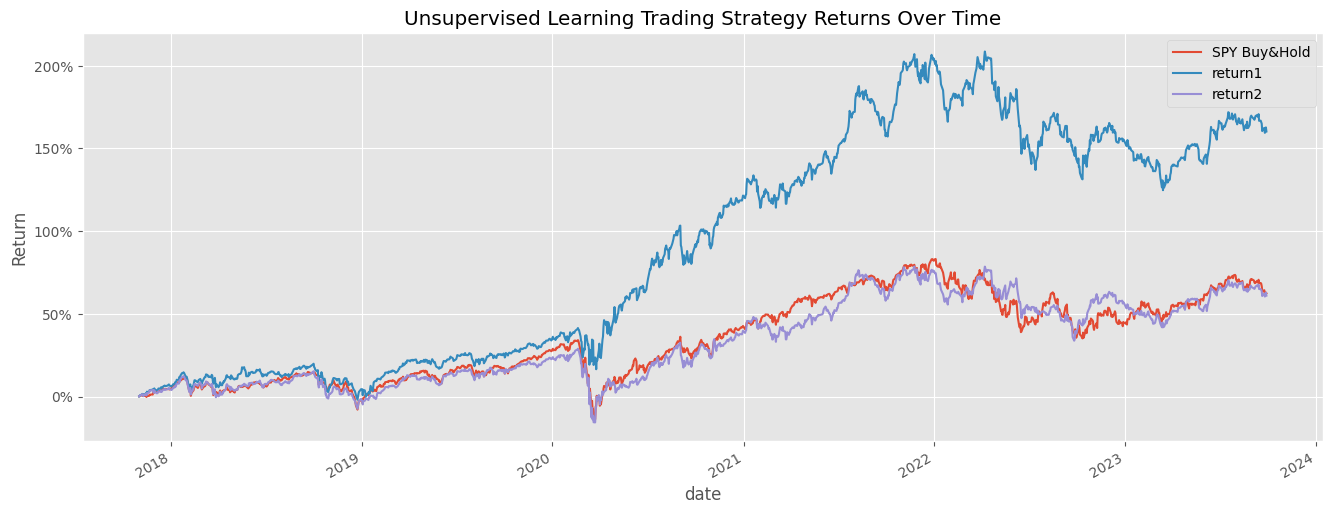

In [59]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
